In [1]:
!pip install Biopython
!pip install wordcloud
!pip install spacy
!pip install gensim
!pip install pyLDAvis
!python -m spacy download en_core_web_sm

import pandas as pd
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer
from pprint import pprint
from gensim.models import CoherenceModel
from gensim import corpora, models
import pyLDAvis
import pyLDAvis.gensim_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-13 18:27:51.030261: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-13 18:27:52.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
df=pd.read_csv('uc1_all_pmids.csv')
df

,PMID
0,31095082
1,29542106
2,33779745
3,30780085
4,33470426
...,...
10500,29700475
10501,34800996
10502,30367059
10503,30643251


In [3]:
lists=df['PMID'].tolist()
len(lists)

10505

In [4]:
from Bio import Entrez

Entrez.email = 'your_email@provider.com'

pmids = lists
handle = Entrez.efetch(db="pubmed", id=','.join(map(str, pmids)),
                       rettype="xml", retmode="text")
records = Entrez.read(handle)


abstract=[]
noma=0
n=0
for pubmed_article in records['PubmedArticle']:
  n=n+1           
  try:
    abstract.append(pubmed_article['MedlineCitation']['Article']['Abstract']['AbstractText'][0])
  except: 
    # abstract.append('\nno abstracts available.\n')
    noma=noma+1
    continue
    


# abstract_dict = dict(zip(pmids, abstracts))
abstract


[StringElement('This article reviews and updates the evidence on the associations between physical activity and risk for cancer, and for mortality in persons with cancer, as presented in the 2018 Physical Activity Guidelines Advisory Committee Scientific Report.', attributes={'Label': 'PURPOSE'}),
 StringElement("Metastatic breast cancer is not a curable disease, but women with metastatic disease are living longer. Surgery to remove the primary tumour is associated with an increased survival in other types of metastatic cancer. Breast surgery is not standard treatment for metastatic disease, however several recent retrospective studies have suggested that breast surgery could increase the women's survival. These studies have methodological limitations including selection bias. A systematic review mapping all randomised controlled trials addressing the benefits and potential harms of breast surgery is ideal to answer this question.", attributes={'Label': 'BACKGROUND', 'NlmCategory': 'BA

In [5]:
print(len(abstract))
print(noma)
print(n)

9812
50
9862


In [6]:
with open("stopwords.txt", "r") as f:
    sw = f.read().split()
    
for w in range(0,len(sw)):
  sw[w]=sw[w].strip()

In [7]:
abstract_=abstract.copy()
# abstract_

In [10]:
import re
import pandas as pd
from nltk.tokenize import word_tokenize

def lemmatize_and_remove_stopwords(sentence,ssww):

  lemmat=WordNetLemmatizer()

  stopWords = nltk.corpus.stopwords.words('english')
  extra = ssww
  stopWords.extend(extra)

  filtered_list = []
  stop_words = stopWords
  words = word_tokenize(sentence)
  for w in words:
      if w.lower() not in stop_words:
          filtered_list.append(lemmat.lemmatize(w))         

  return " ".join(filtered_list)

for x in range(0,len(abstract_)):
  abstract_[x]=re.sub(r'\b[A-Z]+[0-9]*s?\b','', abstract_[x])
  abstract_[x]=re.sub(r'[\(\[].*?[\)\]]','', abstract_[x])
  abstract_[x]=abstract_[x].lower()
  abstract_[x]=re.sub(r'attributes=.*}','',abstract_[x])
  abstract_[x]=re.sub(r'StringElement','',abstract_[x])
  abstract_[x]=re.sub(r'\(.{0,5}\)','',abstract_[x])
  abstract_[x]=re.sub(r'[^\w\s]','',abstract_[x])
  abstract_[x]=re.sub(r'[0-9]',' ',abstract_[x])
  abstract_[x]=re.sub(r'(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', abstract_[x])
  # abstract_[x]=re.sub(r'[a-z]+[^\w]+',' ',abstract_[x])
  abstract_[x]=re.sub(r'\xa0.*',' ',abstract_[x])
  abstract_[x]=lemmatize_and_remove_stopwords(abstract_[x],sw)

In [11]:
abstract_

['update evidence association physical activity person presented physical activity guideline advisory committee scientific',
 'metastatic breast curable woman metastatic living longer surgery remove tumour associated increased metastatic breast surgery standard metastatic recent retrospective suggested breast surgery increase woman methodological limitation selection bias mapping randomised controlled addressing benefit potential harm breast surgery ideal answer question',
 'obesity defined index greater associated significant increase suggested obesity worse obesity',
 'quantify association physical activity breast allcause breast breast recurrence',
 'hypertension associated increased cardiovascular uncertainty exists hypertension poor prognostic factor cancerspecific association preexisting hypertension relapse performed published',
 'fragmented continuously released circulation following apoptosis necrosis cancerous noncancerous released specifically known circulating tumor previou

In [12]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data = abstract_
data_words = list(sent_to_words(data))

In [13]:
dictionary = gensim.corpora.Dictionary(data_words)
bow_corpus = [dictionary.doc2bow(doc) for doc in data_words]

from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [14]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    perplexity_values= []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=dictionary,num_topics=num_topics,random_state=100,update_every=1,passes=10,alpha='auto',per_word_topics=True,)        
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(model.log_perplexity(corpus))


    return model_list, coherence_values, perplexity_values

In [15]:
model_list, coherence_values, perplexity_values = compute_coherence_values(dictionary=dictionary, corpus=corpus_tfidf, texts=data_words, start=10, limit=100, step=20)


Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

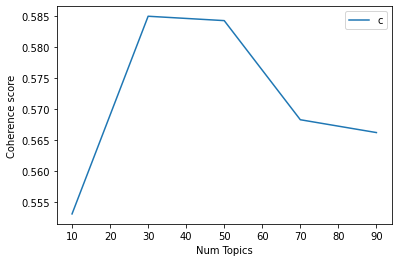

In [16]:
# Show graph
import matplotlib.pyplot as plt

limit=100; start=10; step=20;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [17]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 10  has Coherence Value of 0.5531
Num Topics = 30  has Coherence Value of 0.5849
Num Topics = 50  has Coherence Value of 0.5842
Num Topics = 70  has Coherence Value of 0.5683
Num Topics = 90  has Coherence Value of 0.5662


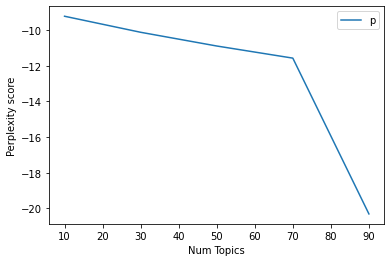

In [18]:
limit=100; start=10; step=20;
x = range(start, limit, step)
plt.plot(x, perplexity_values)
plt.xlabel("Num Topics")
plt.ylabel("Perplexity score")
plt.legend(("perplexity_values"), loc='best')
plt.show()

In [19]:
for m, cv in zip(x, perplexity_values):
    print("Num Topics =", m, " has perplixity Value of", round(cv, 4))

Num Topics = 10  has perplixity Value of -9.2132
Num Topics = 30  has perplixity Value of -10.1137
Num Topics = 50  has perplixity Value of -10.8843
Num Topics = 70  has perplixity Value of -11.5653
Num Topics = 90  has perplixity Value of -20.3142


In [20]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus_tfidf,
                                           id2word=dictionary,
                                           num_topics=30, 
                                           random_state=100,
                                           update_every=1,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True,
                                            )

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

In [21]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus_tfidf]
## topic modeling new improved cleaning 30 topics

[(27,
  '0.015*"pelvic" + 0.010*"cavity" + 0.010*"conducting" + 0.008*"replacement" '
  '+ 0.007*"carcinomatosis" + 0.007*"integrate" + 0.006*"situ" + '
  '0.006*"maxillofacial" + 0.005*"deadly" + 0.005*"aggressiveness"'),
 (22,
  '0.019*"venous" + 0.016*"lymphadenectomy" + 0.016*"thromboembolism" + '
  '0.013*"vein" + 0.012*"anticoagulant" + 0.012*"portal" + 0.010*"infusion" + '
  '0.010*"biochemical" + 0.008*"ligation" + 0.008*"technology"'),
 (16,
  '0.017*"bleeding" + 0.008*"technical" + 0.008*"cumulative" + 0.008*"scheme" '
  '+ 0.008*"pre" + 0.008*"post" + 0.007*"hormonal" + 0.007*"proton" + '
  '0.006*"worker" + 0.006*"microvascular"'),
 (21,
  '0.015*"vaccine" + 0.011*"allogeneic" + 0.010*"leukemia" + 0.009*"nutrition" '
  '+ 0.008*"transplantation" + 0.008*"hematopoietic" + 0.008*"vaccination" + '
  '0.007*"cadherin" + 0.007*"stem" + 0.007*"dendritic"'),
 (20,
  '0.015*"circrnas" + 0.012*"healthrelated" + 0.011*"capecitabine" + '
  '0.010*"recognized" + 0.010*"oropharyngeal" +

In [22]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus_tfidf))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.9/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt


Perplexity:  -10.11370781790554

Coherence Score:  0.5849459067477173


In [23]:
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus_tfidf, dictionary)
vis
## number of topics 30 // with improved cleaning

/usr/local/lib/python3.9/dist-packages/pyLDAvis/_prepare.py:243: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
24    -0.438145 -0.053554       1        1  41.969757
14    -0.385173 -0.006552       2        1  20.448573
12    -0.035985  0.351312       3        1   4.766886
6      0.004039  0.088611       4        1   2.996230
10     0.019017  0.013888       5        1   2.425993
25     0.012179  0.005002       6        1   2.179412
18     0.027479 -0.007537       7        1   1.845197
13     0.029939 -0.007547       8        1   1.660543
28     0.029072 -0.011140       9        1   1.568944
3      0.025909 -0.011945      10        1   1.503231
29     0.031759 -0.012943      11        1   1.465448
7      0.033765 -0.016282      12        1   1.361241
26     0.032262 -0.022881      13        1   1.165599
4      0.036097 -0.024099      14        1   1.069491
5      0.036360 -0.023731      15        1   1.031150
1      0.030669 -0.006176      16        1   0.984830
0      0.034084 -0.002185      17        1   0.984273
17     0.035666 -0.017324      18        1   0.971272
15     0.036512 -0.025343      19        1   0.937430
19     0.035016 -0.018940      20        1   0.893081
2      0.036946 -0.022037      21        1   0.878496
8      0.034883 -0.008886      22        1   0.845281
21     0.037461 -0.009891      23        1   0.819845
9      0.034808 -0.023474      24        1   0.817985
23     0.037169 -0.022214      25        1   0.816121
11     0.037838 -0.022862      26        1   0.793332
22     0.035666 -0.018822      27        1   0.783111
16     0.037884 -0.021905      28        1   0.761698
20     0.038246 -0.021817      29        1   0.752235
27     0.038581 -0.018726      30        1   0.503316, topic_info=               Term        Freq       Total Category  logprob  loglift
101       inhibitor  121.000000  121.000000  Default  30.0000  30.0000
58       prognostic  175.000000  175.000000  Default  29.0000  29.0000
1930   laparoscopic   36.000000   36.000000  Default  28.0000  28.0000
1041            mir   41.000000   41.000000  Default  27.0000  27.0000
81            tumor  154.000000  154.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
5289     myometrial    0.482457    0.984644  Topic30  -6.0524   4.5783
5897       removing    0.457101    0.959289  Topic30  -6.1064   4.5504
2821  institutional    0.565461    1.223180  Topic30  -5.8936   4.5201
2441       specimen    0.920452    2.344359  Topic30  -5.4064   4.3568
233       extension    0.502333    3.635055  Topic30  -6.0120   3.3126

[1212 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2637     16  0.398469    abdominal
2637     24  0.597703    abdominal
1070      3  0.950860      ability
5245     24  0.862123  abiraterone
1982      1  0.361510     ablation
...     ...       ...          ...
3298     28  0.590834      working
2826     25  0.599350        wound
198       1  0.997811         year
968       5  0.897211      younger
2246     16  0.507608      yttrium

[1471 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[25, 15, 13, 7, 11, 26, 19, 14, 29, 4, 30, 8, 27, 5, 6, 2, 1, 18, 16, 20, 3, 9, 22, 10, 24, 12, 23, 17, 21, 28])

In [ ]:
Topic 1: therapy
Topic 2: prognosis,diagnosis
Topic 3: 
Topic 4: Cancer in children
Topic 5: 
Topic 6: surgeries and imaging / operations and procedures
Topic 7: vital/ risks
Topic 8: abdominal
Topic 9: drugs
Topic 10: blood cancer 